In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sports-attendance-data.csv to sports-attendance-data (1).csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
import seaborn as sns
from matplotlib.lines import Line2D

az.rcParams["stats.hdi_prob"] = 0.89
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

/usr/local/lib/python3.12/dist-packages/arviz/rcparams.py:345: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


In [ ]:
df = pd.read_csv("sports-attendance-data.csv")
df.head()

,team,day,attendance
0,River Plate,Monday,32729.0
1,River Plate,Saturday,31915.0
2,River Plate,Thursday,NaN
3,River Plate,Thursday,31512.0
4,River Plate,Friday,23361.0


In [ ]:
df.info()

print("\nSummary statistics for attendance:")
print(df["attendance"].describe())

print("\nNumber of missing attendance values:")
print(df["attendance"].isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   team        240 non-null    object 
 1   day         240 non-null    object 
 2   attendance  218 non-null    float64
dtypes: float64(1), object(2)
memory usage: 5.8+ KB

Summary statistics for attendance:
count      218.000000
mean     23649.981651
std      11347.890378
min       2205.000000
25%      15074.000000
50%      22635.500000
75%      30000.000000
max      66152.000000
Name: attendance, dtype: float64

Number of missing attendance values:
22


In [ ]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

df["day"] = pd.Categorical(df["day"], categories=day_order, ordered=True)

# encode team and day as integer indices
df["team"] = pd.Categorical(df["team"])
df["team_idx"] = df["team"].cat.codes
df["day_idx"] = df["day"].cat.codes

n_teams = df["team"].nunique()
n_days = df["day"].nunique()

print("n_teams:", n_teams)
print("n_days:", n_days)
df.head()


n_teams: 12
n_days: 7


,team,day,attendance,team_idx,day_idx
0,River Plate,Monday,32729.0,7,0
1,River Plate,Saturday,31915.0,7,5
2,River Plate,Thursday,NaN,7,3
3,River Plate,Thursday,31512.0,7,3
4,River Plate,Friday,23361.0,7,4


/tmp/ipython-input-808089348.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("team")["missing_attendance"]


Fraction of games with missing attendance: 0.092
team
River Plate           0.25
Huracán               0.15
Racing                0.15
Vélez Sarsfield       0.15
Independiente         0.10
Lanús                 0.10
Argentinos Juniors    0.10
Boca Juniors          0.05
Talleres (C)          0.05
Godoy Cruz            0.00
San Lorenzo           0.00
Rosario Central       0.00
Name: missing_attendance, dtype: float64


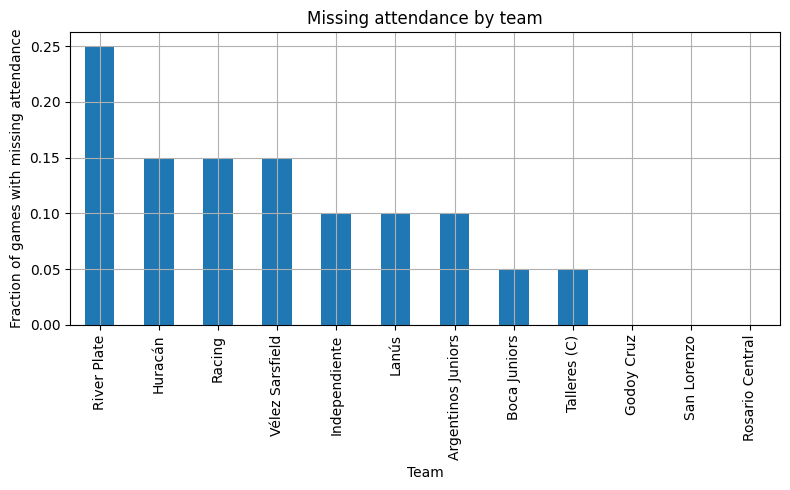

day
Tuesday      0.153846
Wednesday    0.142857
Monday       0.093750
Saturday     0.093750
Sunday       0.057143
Thursday     0.055556
Friday       0.052632
Name: missing_attendance, dtype: float64


/tmp/ipython-input-808089348.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("day")["missing_attendance"]


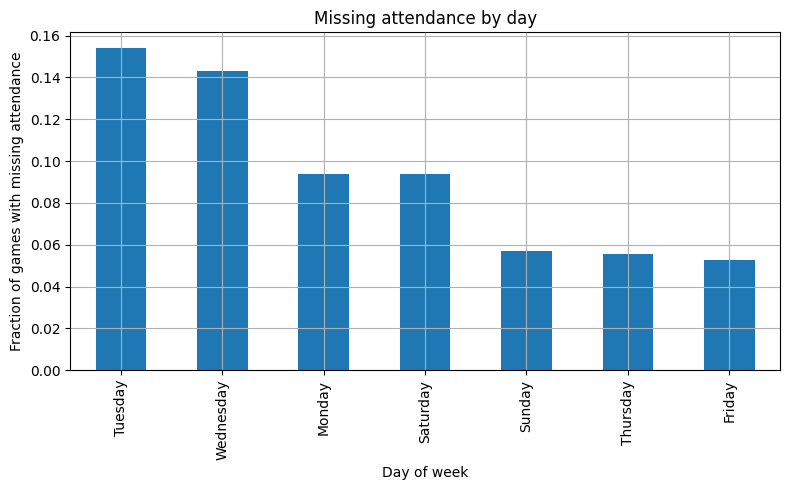

In [ ]:
df["missing_attendance"] = df["attendance"].isna()

print("Fraction of games with missing attendance:",
      df["missing_attendance"].mean().round(3))

missing_by_team = (
    df.groupby("team")["missing_attendance"]
      .mean()
      .sort_values(ascending=False)
)

print(missing_by_team)


fig, ax = plt.subplots()
missing_by_team.plot(kind="bar", ax=ax)
ax.set_ylabel("Fraction of games with missing attendance")
ax.set_xlabel("Team")
ax.set_title("Missing attendance by team")
plt.tight_layout()
plt.show()


missing_by_day = (
    df.groupby("day")["missing_attendance"]
      .mean()
      .sort_values(ascending=False)
)

print(missing_by_day)

fig, ax = plt.subplots()
missing_by_day.plot(kind="bar", ax=ax)
ax.set_ylabel("Fraction of games with missing attendance")
ax.set_xlabel("Day of week")
ax.set_title("Missing attendance by day")
plt.tight_layout()
plt.show()


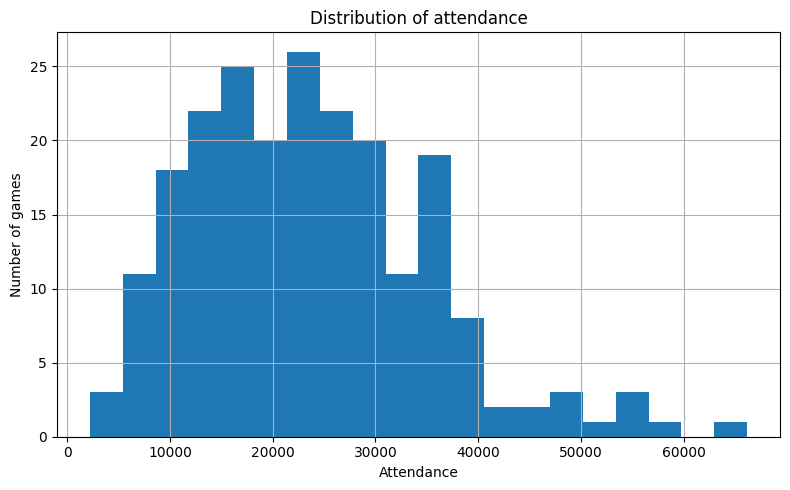

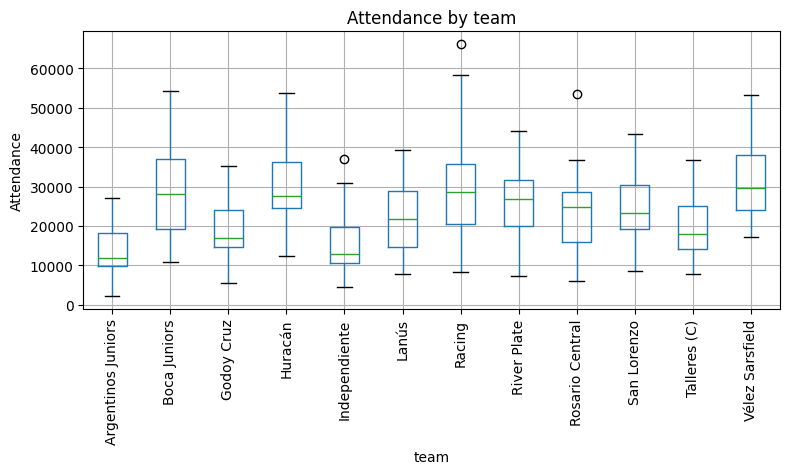

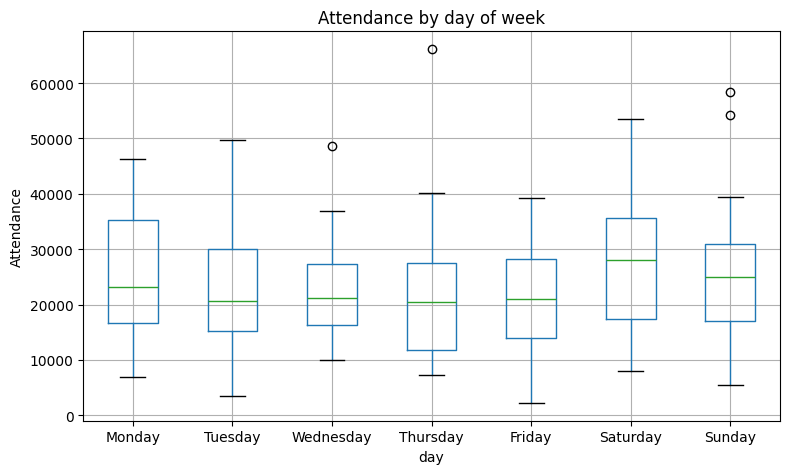

In [ ]:
df_obs = df.dropna(subset=["attendance"]).copy()

fig, ax = plt.subplots()
ax.hist(df_obs["attendance"], bins=20)
ax.set_xlabel("Attendance")
ax.set_ylabel("Number of games")
ax.set_title("Distribution of attendance")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots()
df_obs.boxplot(column="attendance", by="team", ax=ax, rot=90)
ax.set_ylabel("Attendance")
ax.set_title("Attendance by team")
plt.suptitle("")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
df_obs.boxplot(column="attendance", by="day", ax=ax)
ax.set_ylabel("Attendance")
ax.set_title("Attendance by day of week")
plt.suptitle("")
plt.tight_layout()
plt.show()

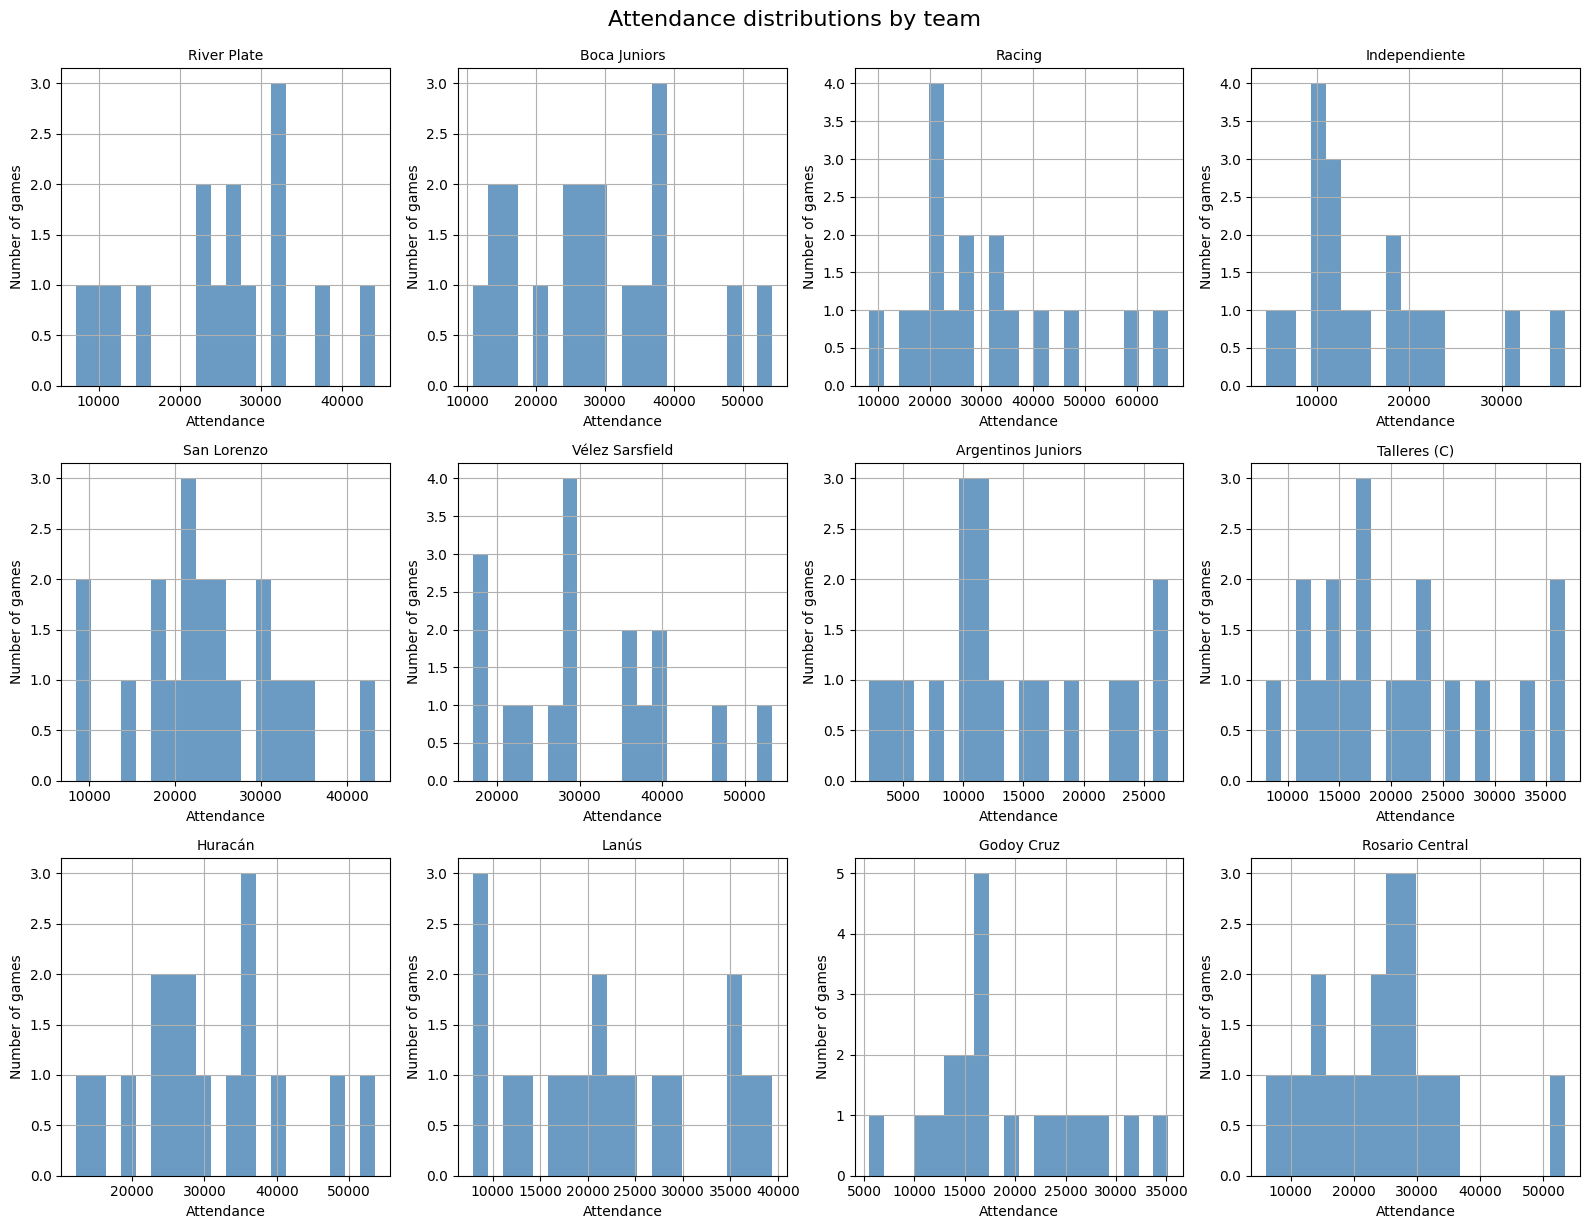

In [ ]:
teams = df["team"].unique()

n_cols = 4
n_rows = int(np.ceil(n_teams / n_cols))

plt.figure(figsize=(16, 12))

for i, team in enumerate(teams):
    plt.subplot(n_rows, n_cols, i + 1)
    values = df.loc[(df["team"] == team) & df["attendance"].notna(), "attendance"]

    plt.hist(values, bins=20, color="steelblue", alpha=0.8)
    plt.title(team, fontsize=10)
    plt.xlabel("Attendance")
    plt.ylabel("Number of games")

plt.tight_layout()
plt.suptitle("Attendance distributions by team", y=1.02, fontsize=16)
plt.show()


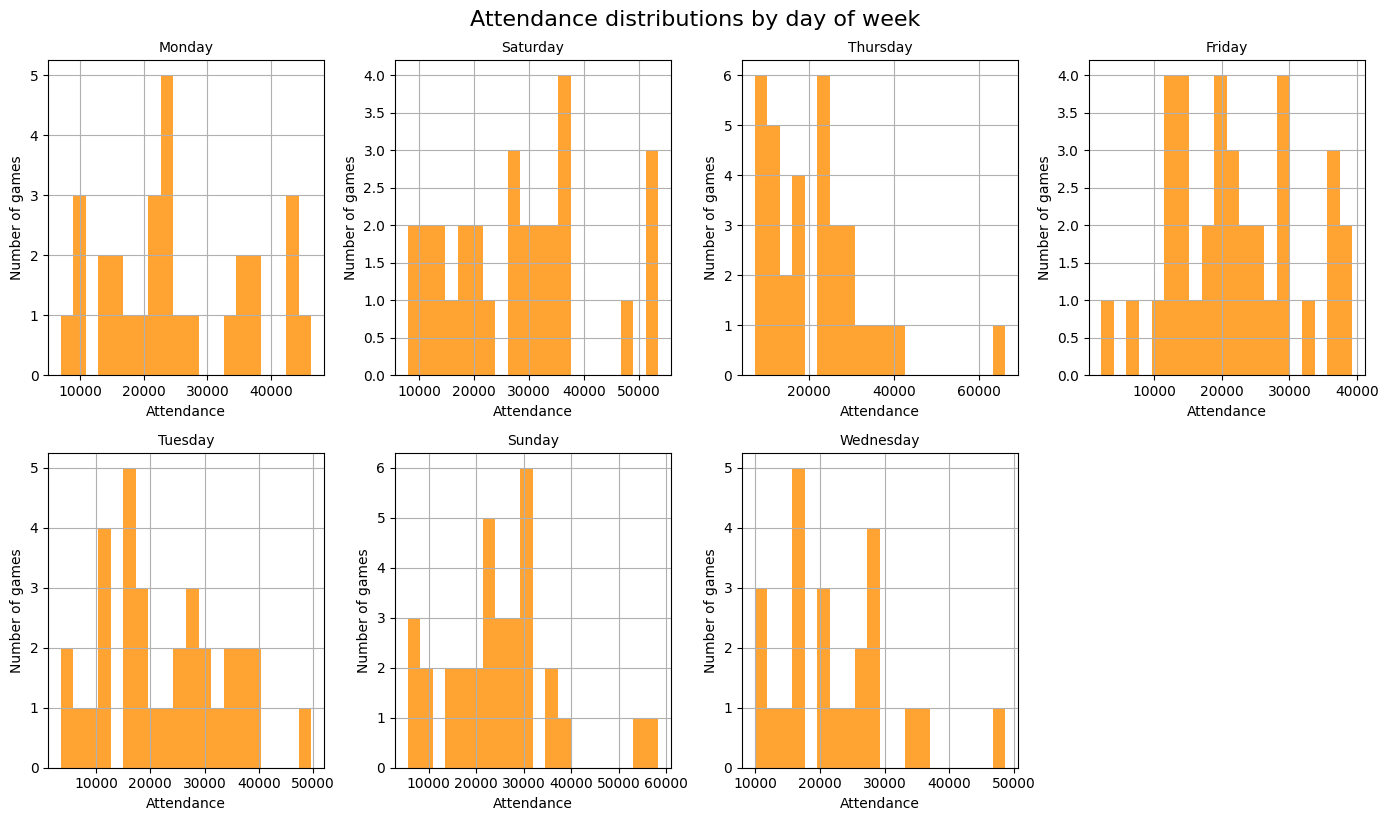

In [ ]:
days = df["day"].unique()

n_cols = 4
n_rows = int(np.ceil(n_days / n_cols))

plt.figure(figsize=(14, 8))

for i, day in enumerate(days):
    plt.subplot(n_rows, n_cols, i + 1)
    values = df.loc[(df["day"] == day) & df["attendance"].notna(), "attendance"]

    plt.hist(values, bins=20, color="darkorange", alpha=0.8)
    plt.title(day, fontsize=10)
    plt.xlabel("Attendance")
    plt.ylabel("Number of games")

plt.tight_layout()
plt.suptitle("Attendance distributions by day of week", y=1.02, fontsize=16)
plt.show()


In [ ]:
mask_observed = df["attendance"].notna()

attendance_observed = df.loc[mask_observed, "attendance"].values
team_idx_observed  = df.loc[mask_observed, "team_idx"].values
day_idx_observed   = df.loc[mask_observed, "day_idx"].values

mask_missing = df["attendance"].isna()

team_idx_missing = df.loc[mask_missing, "team_idx"].values
day_idx_missing  = df.loc[mask_missing, "day_idx"].values

In [ ]:
print("mean (attendance):", attendance_observed.mean())
print("variance (attendance):", attendance_observed.var())

mean (attendance): 23649.981651376147
variance (attendance): 128183906.77947985


In [ ]:
with pm.Model() as complete_pooling_model:

    log_mu = pm.Normal("log_mu", mu = np.log(27000), sigma=0.3)
    mu = pm.Deterministic("mu", pm.math.exp(log_mu))

    alpha = pm.Gamma("alpha", alpha=2, beta=0.1)

    y_observed = pm.NegativeBinomial("y_observed", mu=mu, alpha=alpha, observed=attendance_observed)

    prior_predictive_cp = pm.sample_prior_predictive(random_seed=42)

    inference_cp = pm.sample(chains=4, draws=2000, tune=2000, target_accept=0.9, random_seed=42)

    # posterior predictive
    posterior_predictive_cp = pm.sample_posterior_predictive(inference_cp, random_seed=42)

Output()

Output()

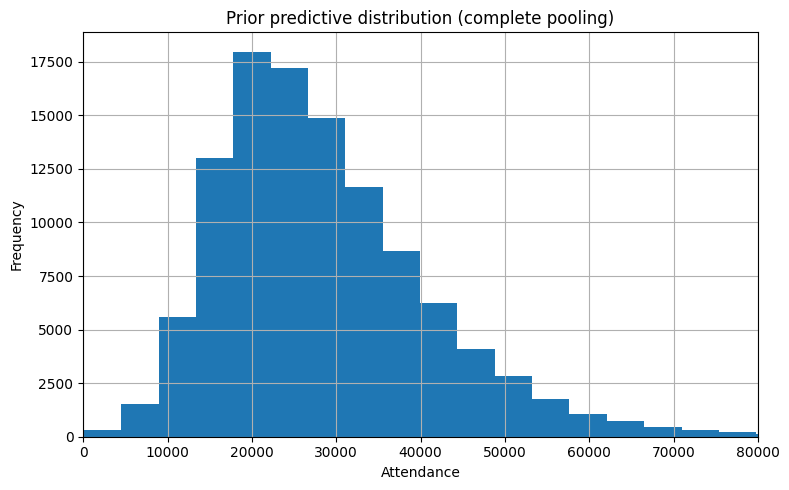

Prior predictive quantiles: [ 7549.97 12250.95 26360.   52293.   69327.  ]


In [ ]:
prior_predictive_check_cp = prior_predictive_cp.prior_predictive["y_observed"].values.flatten()

fig, ax = plt.subplots()
ax.hist(prior_predictive_check_cp, bins=50)
ax.set_xlim(0, 80000)
ax.set_xlabel("Attendance")
ax.set_ylabel("Frequency")
ax.set_title("Prior predictive distribution (complete pooling)")
plt.tight_layout()
plt.show()

print("Prior predictive quantiles:", np.percentile(prior_predictive_check_cp, [1, 5, 50, 95, 99]))

In [ ]:
az.summary(
    inference_cp,
    var_names=["log_mu", "mu", "alpha"],
    round_to=2
)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_mu,10.07,0.03,10.02,10.13,0.00,0.0,6282.27,5261.58,1.0
mu,23718.58,793.57,22419.46,24969.01,10.03,8.7,6282.27,5261.58,1.0
alpha,4.10,0.37,3.52,4.70,0.00,0.0,8015.23,5632.37,1.0


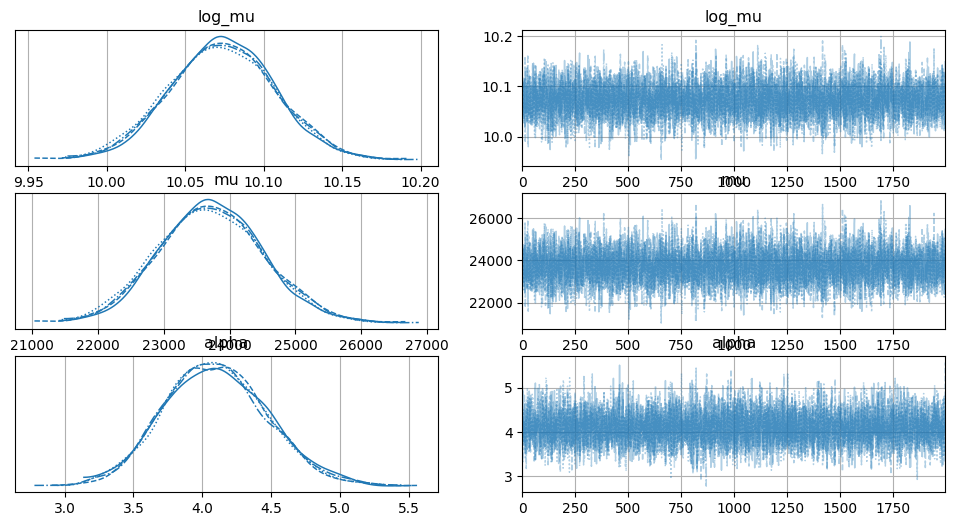

In [ ]:
az.plot_trace(inference_cp, var_names=["log_mu", "mu", "alpha"])
plt.show()

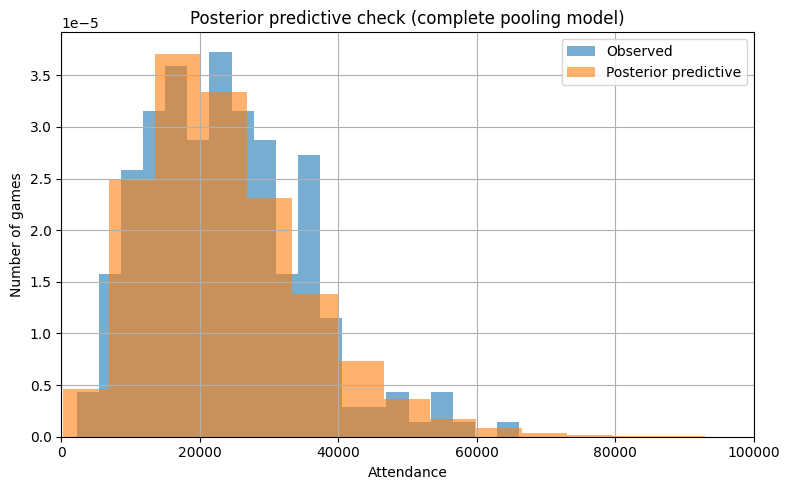

In [ ]:
posterior_cp = posterior_predictive_cp.posterior_predictive["y_observed"].values.flatten()

fig, ax = plt.subplots()
ax.hist(attendance_observed, bins=20, alpha=0.6, density=True, label="Observed")
ax.hist(posterior_cp, bins=20, alpha=0.6, density=True, label="Posterior predictive")
ax.set_xlim(0, 100000)
ax.set_xlabel("Attendance")
ax.set_ylabel("Number of games")
ax.set_title("Posterior predictive check (complete pooling model)")
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
with pm.Model() as hierarchical_model:

    log_mu_global = pm.Normal("log_mu_global", mu=np.log(27000), sigma=0.3)

    sigma_team = pm.HalfNormal("sigma_team", sigma = 0.2)
    z_team = pm.Normal("z_team", mu=0, sigma=1, shape=n_teams)
    u_team = pm.Deterministic("u_team", z_team * sigma_team)

    sigma_day = pm.HalfNormal("sigma_day", sigma = 0.2)
    z_day = pm.Normal("z_day", mu=0, sigma=1, shape=n_days)
    v_day = pm.Deterministic("v_day", z_day * sigma_day)

    log_mu = log_mu_global + u_team[team_idx_observed] + v_day[day_idx_observed]
    mu = pm.Deterministic("mu", pm.math.exp(log_mu))

    alpha = pm.Gamma("alpha", alpha=2, beta=0.1)

    y_observed_hier = pm.NegativeBinomial(
        "y_observed_hier",
        mu=mu,
        alpha=alpha,
        observed=attendance_observed
    )

    prior_predictive_hier = pm.sample_prior_predictive(random_seed=42)

    inference_hier = pm.sample(
        chains=4,
        draws=2000,
        tune=2000,
        target_accept=0.9,
        random_seed=42
    )

    posterior_predictive_hier = pm.sample_posterior_predictive(
        inference_hier, random_seed=42
    )


Output()

Output()

In [ ]:
prior_predictive_check_hier = prior_predictive_hier.prior_predictive["y_observed_hier"].values.flatten()
np.percentile(prior_predictive_check_hier, [1,5,50,95,99])

array([ 6093.96, 10628.  , 26424.5 , 61838.  , 90819.08])

In [ ]:
az.summary(inference_hier, var_names=["log_mu_global", "sigma_team", "sigma_day", "alpha"], round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_mu_global,10.06,0.08,9.93,10.18,0.0,0.00,2759.99,4170.32,1.0
sigma_team,0.24,0.06,0.15,0.33,0.0,0.00,2951.47,5260.43,1.0
sigma_day,0.05,0.04,0.00,0.10,0.0,0.00,3158.78,2965.95,1.0
alpha,5.03,0.47,4.24,5.73,0.0,0.01,11038.62,5925.84,1.0


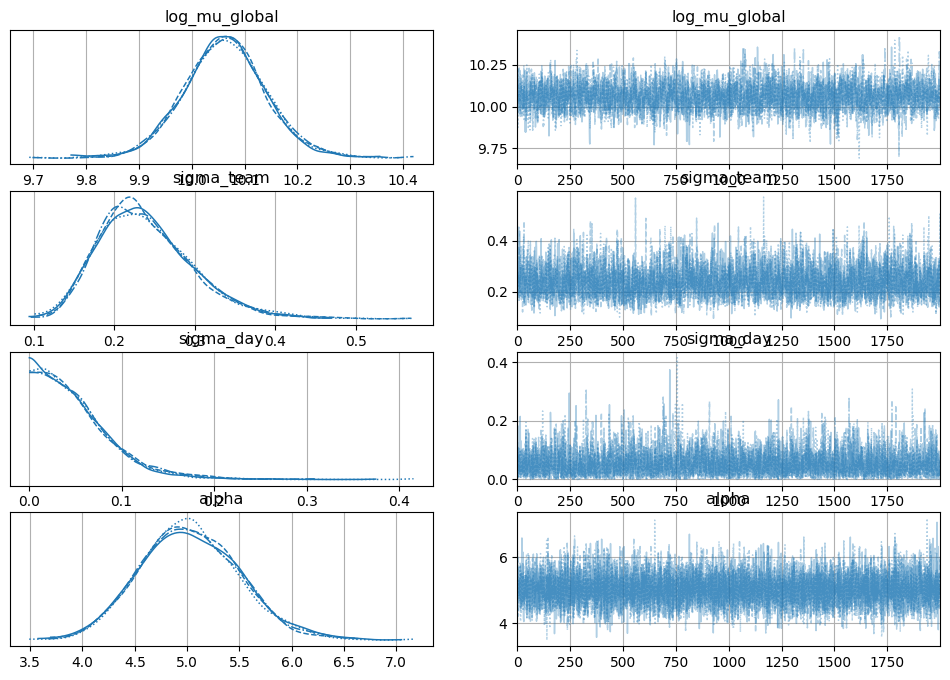

In [ ]:
az.plot_trace(inference_hier, var_names=["log_mu_global", "sigma_team", "sigma_day", "alpha"])
plt.show()


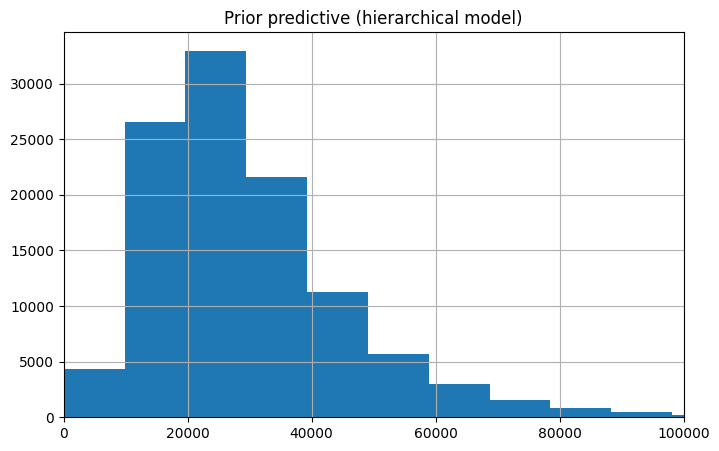

In [ ]:
plt.hist(prior_predictive_check_hier, bins=50)
plt.xlim(0, 100000)
plt.title("Prior predictive (hierarchical model)")
plt.show()


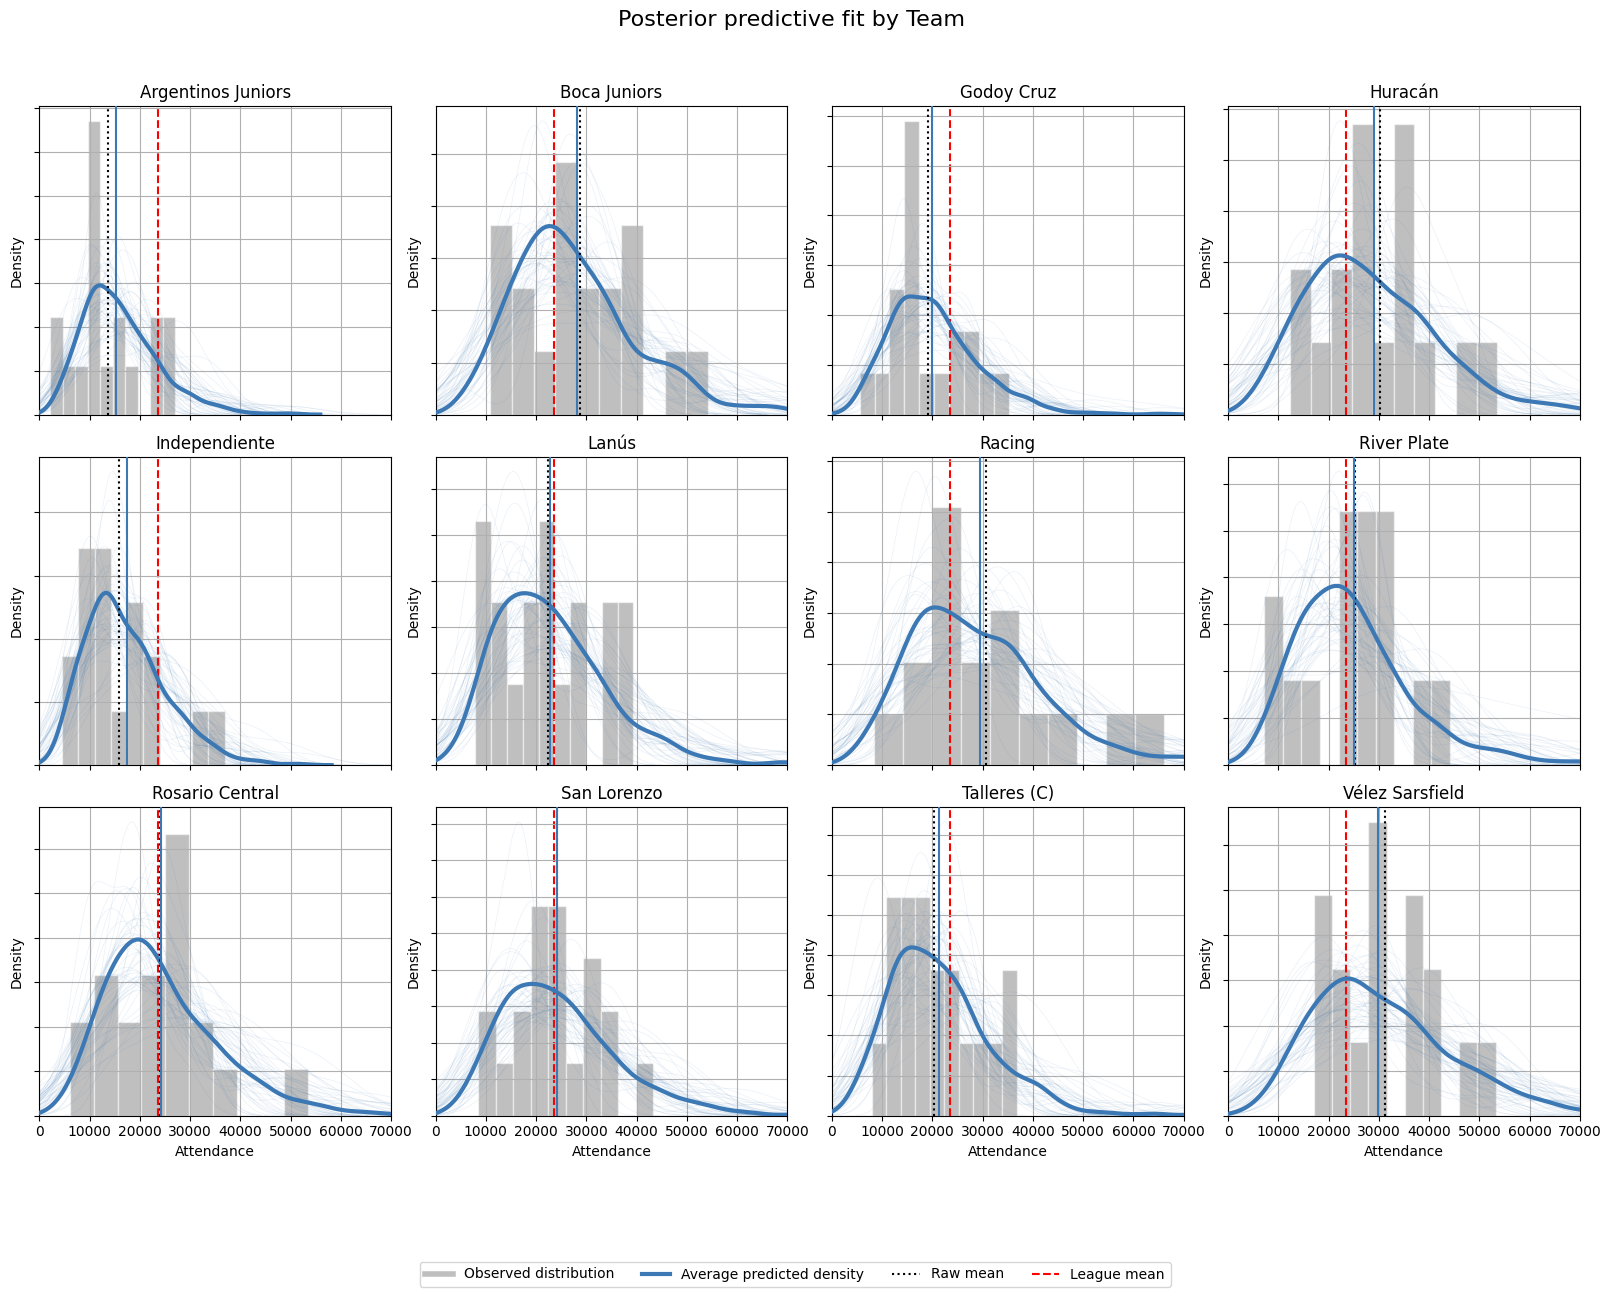

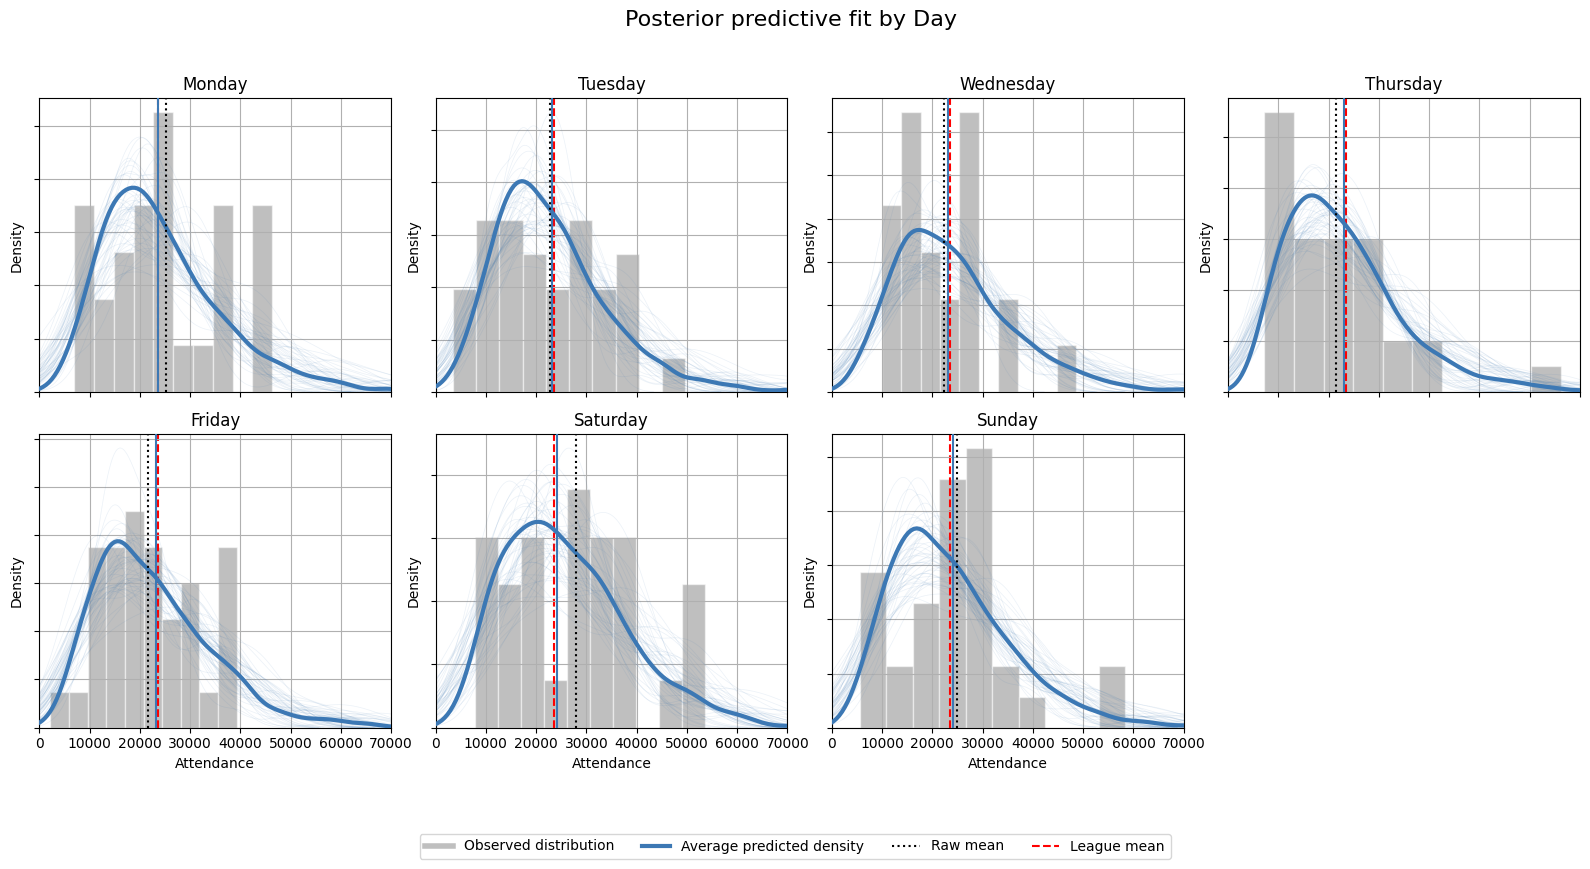

In [ ]:
ppc_samples = posterior_predictive_hier.posterior_predictive["y_observed_hier"]

ppc_flat = ppc_samples.stack(sample=("chain", "draw")).values.T
n_total_samples = ppc_flat.shape[0]

league_mean = np.exp(inference_hier.posterior['log_mu_global']).mean().item()

log_mu_global = inference_hier.posterior['log_mu_global'].values.flatten()

u_team = inference_hier.posterior['u_team'].stack(sample=("chain", "draw")).values.T
v_day = inference_hier.posterior['v_day'].stack(sample=("chain", "draw")).values.T


def get_posterior_mean_for_group(group_type, index):
    if group_type == 'team':
        log_mean_samples = log_mu_global + u_team[:, index]
    else:
        log_mean_samples = log_mu_global + v_day[:, index]

    return np.exp(log_mean_samples).mean().item()


def plot_group_ppc(group_names, group_indices_observed, group_type, n_samples=50):

    n_groups = len(group_names)
    n_cols = 4
    n_rows = int(np.ceil(n_groups / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows), sharex=True, sharey=False)
    axes = axes.flatten()

    fig.suptitle(f"Posterior predictive fit by {group_type.capitalize()} ", fontsize=16, y=1.02)

    sample_indices = np.random.choice(n_total_samples, n_samples, replace=False)

    for i, group_name in enumerate(group_names):
        ax = axes[i]

        g_idx = np.where(group_names == group_name)[0][0]
        mask = (group_indices_observed == g_idx)

        obs_data = attendance_observed[mask]

        pred_data_subset = ppc_flat[sample_indices, :][:, mask]

        raw_mean = np.nanmean(obs_data)
        posterior_mean = get_posterior_mean_for_group(group_type, g_idx)

        ax.hist(obs_data, density=True, alpha=0.5, color='gray', edgecolor='white', bins=10, label='Observed data')

        for sample in pred_data_subset:
            sns.kdeplot(sample, ax=ax, color='#3C78B4', alpha=0.1, linewidth=0.5, zorder=2)

        sns.kdeplot(pred_data_subset.flatten(), ax=ax, color='#3C78B4', linewidth=3, label='Average predicted density', zorder=3)


        ax.axvline(raw_mean, color='black', linestyle=':', label='Raw mean', zorder=4, linewidth=1.5)
        ax.axvline(posterior_mean, color='#3C78B4', linestyle='-', label='Posterior mean', zorder=5, linewidth=1.5)
        ax.axvline(league_mean, color='red', linestyle='--', label='League mean', zorder=1, linewidth=1.5)

        ax.set_title(group_name)
        ax.set_xlabel("Attendance")
        ax.set_yticklabels([])
        ax.ticklabel_format(style='plain', axis='x')
        ax.set_xlim(0, 70000)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    custom_lines = [
        Line2D([0], [0], color='gray', lw=4, alpha=0.5),
        Line2D([0], [0], color='#3C78B4', lw=3),
        Line2D([0], [0], color='black', linestyle=':', lw=1.5),
        Line2D([0], [0], color='red', linestyle='--', lw=1.5)
    ]
    labels = ['Observed distribution', 'Average predicted density', 'Raw mean', 'League mean']
    fig.legend(custom_lines, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))

    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()


team_names = df['team'].cat.categories
day_names = df['day'].cat.categories

plot_group_ppc(team_names, team_idx_observed, 'team')
plot_group_ppc(day_names, day_idx_observed, 'day')

/tmp/ipython-input-261152978.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  raw_mean = df.groupby("team")["attendance"].mean().reindex(group_names).values


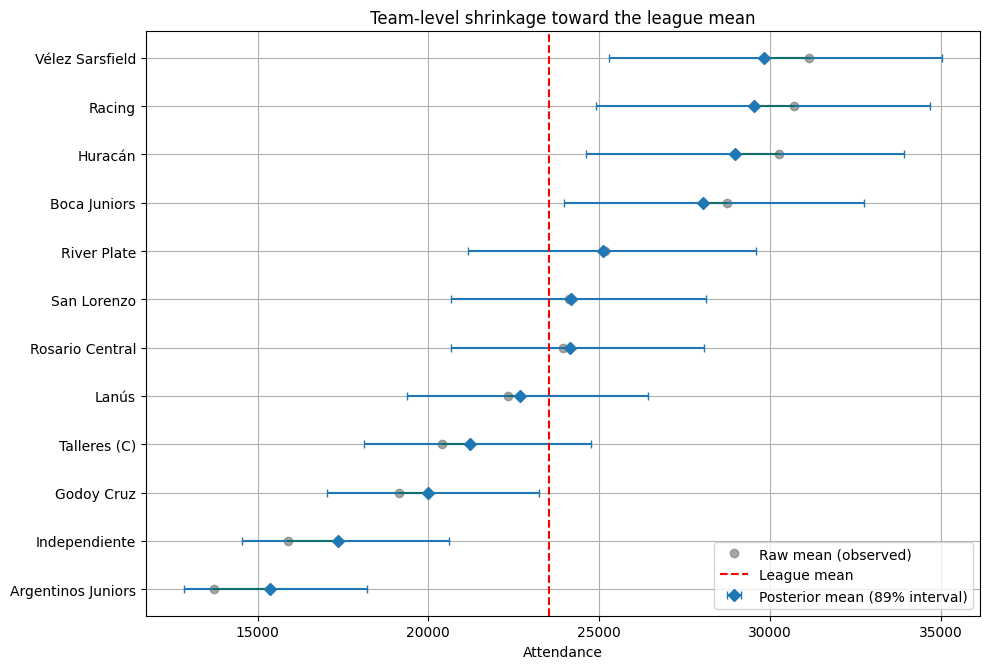

/tmp/ipython-input-261152978.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  raw_mean = df.groupby("day")["attendance"].mean().reindex(group_names).values


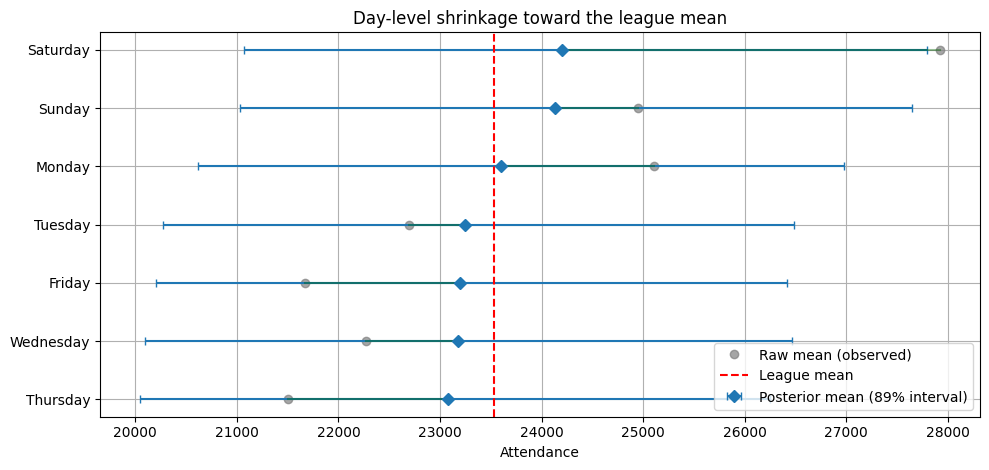

In [ ]:
def get_group_stats(group_type, group_names):
    if group_type == "team":
        group_eff = u_team
        raw_mean = df.groupby("team")["attendance"].mean().reindex(group_names).values
    else:
        group_eff = v_day
        raw_mean = df.groupby("day")["attendance"].mean().reindex(group_names).values

    log_mu_samples = log_mu_global[:, None] + group_eff
    mu_samples = np.exp(log_mu_samples)

    post_mean = mu_samples.mean(axis=0)
    hdi_lower = np.percentile(mu_samples, 5.5, axis=0)
    hdi_upper = np.percentile(mu_samples, 94.5, axis=0)

    return raw_mean, post_mean, hdi_lower, hdi_upper


def plot_shrinkage_forest(group_type, group_names):
    raw_mean, post_mean, hdi_l, hdi_u = get_group_stats(group_type, group_names)

    idx = np.argsort(post_mean)
    gnames = group_names[idx]
    rm = raw_mean[idx]
    pm = post_mean[idx]
    lo = hdi_l[idx]
    hi = hdi_u[idx]

    y = np.arange(len(gnames))
    err_lower = pm - lo
    err_upper = hi - pm

    fig, ax = plt.subplots(figsize=(10, 0.4 * len(gnames) + 2))

    ax.plot(rm, y, "o", color="gray", alpha=0.7, label="Raw mean (observed)")

    ax.errorbar(
        pm, y,
        xerr=[err_lower, err_upper],
        fmt="D",
        color="tab:blue",
        capsize=3,
        label="Posterior mean (89% interval)"
    )

    ax.axvline(league_mean, color="red", linestyle="--", label="League mean")

    for i in range(len(gnames)):
        ax.plot([rm[i], pm[i]], [y[i], y[i]], color="darkgreen", alpha=0.4)

    ax.set_yticks(y)
    ax.set_yticklabels(gnames)
    ax.set_xlabel("Attendance")
    ax.set_title(f"{group_type.capitalize()}-level shrinkage toward the league mean")
    ax.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


plot_shrinkage_forest("team", team_names)
plot_shrinkage_forest("day", day_names)


In [ ]:
with complete_pooling_model:
    inference_cp = pm.compute_log_likelihood(
        inference_cp, extend_inferencedata=True
    )

with hierarchical_model:
    inference_hier = pm.compute_log_likelihood(
        inference_hier, extend_inferencedata=True
    )

Output()

Output()

                  rank     elpd_loo      p_loo  elpd_diff  weight         se  \
hierarchical         0 -2316.595396  12.179417   0.000000     1.0  10.330620   
complete_pooling     1 -2335.062519   2.008372  18.467123     0.0  10.465103   

                      dse  warning scale  
hierarchical      0.00000    False   log  
complete_pooling  5.54858    False   log  


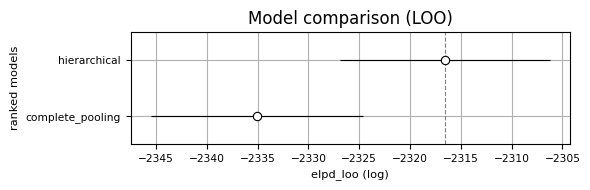

In [ ]:
model_compare = az.compare({"complete_pooling": inference_cp, "hierarchical": inference_hier,}, ic="loo" )

print(model_compare)

az.plot_compare(model_compare)
plt.title("Model comparison (LOO)")
plt.tight_layout()
plt.show()

In [ ]:
missing_team_idx = df.loc[mask_missing, "team_idx"].values
missing_day_idx  = df.loc[mask_missing, "day_idx"].values

# flatten log_mu_global to (n_samples,)
log_mu_samples = inference_hier.posterior["log_mu_global"].values.reshape(-1)

# reshape u_team to (n_samples, n_teams)
u_team_samples = inference_hier.posterior["u_team"].values.reshape(-1, n_teams)

# reshape v_day to (n_samples, n_days)
v_day_samples = inference_hier.posterior["v_day"].values.reshape(-1, n_days)

# extract alpha
alpha_samples = inference_hier.posterior["alpha"].values.reshape(-1)

N_samp = log_mu_samples.shape[0]
N_miss = len(missing_team_idx)

mu_missing = np.zeros((N_samp, N_miss))

for i in range(N_miss):
    t = missing_team_idx[i]
    d = missing_day_idx[i]
    mu_missing[:, i] = np.exp(log_mu_samples + u_team_samples[:, t] + v_day_samples[:, d])

# sample NB for missing observations
rng = np.random.default_rng(42)
y_missing_samples = rng.negative_binomial(
    n=alpha_samples[:, None],
    p=alpha_samples[:, None] / (alpha_samples[:, None] + mu_missing),
    size=mu_missing.shape
)

missing_mean = y_missing_samples.mean(axis=0)
missing_hdi = az.hdi(y_missing_samples, hdi_prob=0.89)

df_missing_pred = df.loc[mask_missing, ["team", "day"]].copy()
df_missing_pred["pred_mean"] = missing_mean
df_missing_pred["hdi_lower"] = missing_hdi[:, 0]
df_missing_pred["hdi_upper"] = missing_hdi[:, 1]

df_missing_pred


/tmp/ipython-input-122105506.py:35: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  missing_hdi = az.hdi(y_missing_samples, hdi_prob=0.89)


,team,day,pred_mean,hdi_lower,hdi_upper
2,River Plate,Thursday,24652.617000,7630.0,40911.0
7,River Plate,Tuesday,24795.062500,7384.0,40788.0
10,River Plate,Friday,24988.084125,7571.0,41737.0
14,River Plate,Monday,25214.279375,7642.0,41876.0
17,River Plate,Tuesday,24789.108750,7473.0,40937.0
29,Boca Juniors,Wednesday,27603.466250,7913.0,45716.0
48,Racing,Tuesday,29140.351125,8944.0,48350.0
51,Racing,Sunday,30026.217375,8934.0,49273.0
58,Racing,Tuesday,29163.362375,8313.0,47963.0
64,Independiente,Tuesday,17101.043125,5252.0,28110.0


/tmp/ipython-input-2870868331.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ).groupby("team").agg(
/tmp/ipython-input-2870868331.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ).groupby("day").agg(


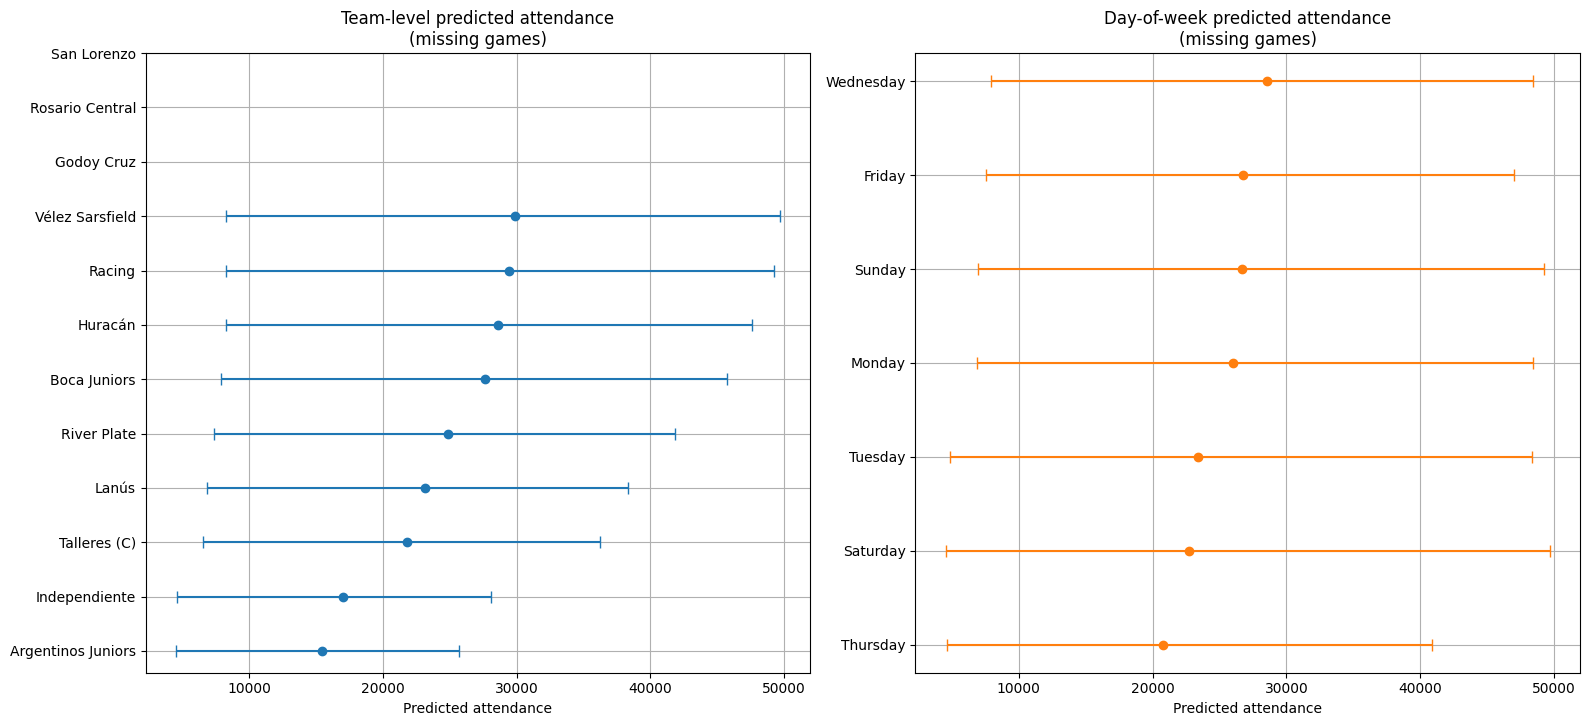

In [ ]:
agg_team = df_missing_pred.assign(
    mean = missing_mean,
    lower = missing_hdi[:, 0],
    upper = missing_hdi[:, 1]
).groupby("team").agg(
    pred_mean=("mean", "mean"),
    hdi_lower=("lower", "min"),
    hdi_upper=("upper", "max"),
    n_missing=("mean", "count")
)

agg_day = df_missing_pred.assign(
    mean = missing_mean,
    lower = missing_hdi[:, 0],
    upper = missing_hdi[:, 1]
).groupby("day").agg(
    pred_mean=("mean", "mean"),
    hdi_lower=("lower", "min"),
    hdi_upper=("upper", "max"),
    n_missing=("mean", "count")
)


agg_team = agg_team.sort_values("pred_mean")
agg_day = agg_day.sort_values("pred_mean")

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=False)

ax = axes[0]
y = np.arange(len(agg_team))

ax.errorbar(
    agg_team["pred_mean"], y,
    xerr=[agg_team["pred_mean"] - agg_team["hdi_lower"],
          agg_team["hdi_upper"] - agg_team["pred_mean"]],
    fmt="o", color="tab:blue", capsize=4
)

ax.set_yticks(y)
ax.set_yticklabels(agg_team.index)
ax.set_xlabel("Predicted attendance")
ax.set_title("Team-level predicted attendance\n(missing games)")

ax = axes[1]
y = np.arange(len(agg_day))

ax.errorbar(
    agg_day["pred_mean"], y,
    xerr=[agg_day["pred_mean"] - agg_day["hdi_lower"],
          agg_day["hdi_upper"] - agg_day["pred_mean"]],
    fmt="o", color="tab:orange", capsize=4
)

ax.set_yticks(y)
ax.set_yticklabels(agg_day.index)
ax.set_xlabel("Predicted attendance")
ax.set_title("Day-of-week predicted attendance\n(missing games)")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
team_pred_sd  = agg_team["pred_mean"].std()
day_pred_sd  = agg_day["pred_mean"].std()

team_pred_sd, day_pred_sd

(5307.740008198409, 2736.619771282454)